In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [00:31<00:00, 95.7MB/s]
100% 2.13G/2.13G [00:31<00:00, 71.4MB/s]


In [ ]:
import zipfile
# Unzipping the dataset
with zipfile.ZipFile('/content/leapgestrecog.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
def gather_image_paths_and_labels(root_dir):
    file_paths = []
    labels = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                file_paths.append(os.path.join(root, file))
                label = os.path.basename(os.path.dirname(root))
                labels.append(label)
    return file_paths, labels

In [ ]:
file_paths, labels = gather_image_paths_and_labels("/content/leapGestRecog")
df = pd.DataFrame({'file_path': file_paths, 'label': labels})
df.head()

,file_path,label
0,/content/leapGestRecog/05/01_palm/frame_05_01_...,05
1,/content/leapGestRecog/05/01_palm/frame_05_01_...,05
2,/content/leapGestRecog/05/01_palm/frame_05_01_...,05
3,/content/leapGestRecog/05/01_palm/frame_05_01_...,05
4,/content/leapGestRecog/05/01_palm/frame_05_01_...,05


In [ ]:
img_height, img_width = 224, 224
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    df,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 16000 validated image filenames belonging to 10 classes.


In [ ]:
validation_generator = datagen.flow_from_dataframe(
    df,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)
num_classes = len(train_generator.class_indices)

Found 4000 validated image filenames belonging to 10 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
epochs = 2

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/2
500/500 [==============================] - 2246s 4s/step - loss: 0.1274 - accuracy: 0.9566 - val_loss: 16.7908 - val_accuracy: 0.0000e+00
Epoch 2/2
500/500 [==============================] - 2354s 5s/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 27.2036 - val_accuracy: 0.0000e+00


In [ ]:
validation_loss, validation_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {validation_acc}")

125/125 [==============================] - 140s 1s/step - loss: 27.2036 - accuracy: 0.0000e+00
Validation Accuracy: 0.0


In [ ]:
def predict_hand_gesture(img_path, model):
    img = load_img(img_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])

    class_indices = {v: k for k, v in train_generator.class_indices.items()}
    gesture = class_indices[predicted_class]

    return gesture, img

In [ ]:
import random
validation_file_paths = validation_generator.filepaths
random_img_path = random.choice(validation_file_paths)
predicted_gesture, img = predict_hand_gesture(random_img_path, model)
print(f"Predicted Gesture: {predicted_gesture}")

1/1 [==============================] - 0s 117ms/step
Predicted Gesture: 02


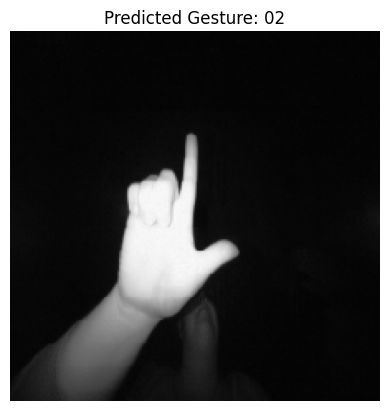

In [ ]:
plt.imshow(img)
plt.title(f"Predicted Gesture: {predicted_gesture}")
plt.axis('off')
plt.show()